In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [0]:
num_noise = batch_size = 100
num_hidden = 256

cuda_available = torch.cuda.is_available()

In [3]:
# standardization code
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), ])

# MNIST dataset
train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_data  = torchvision.datasets.MNIST(root='data/', train=False, transform=transform, download=True)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 9330164.91it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142386.60it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2238399.95it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 53212.01it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


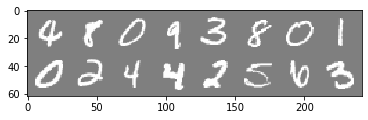

In [4]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = torchvision.utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        conv2d_1 = torch.nn.ConvTranspose2d(in_channels=num_noise,
                                   out_channels=28*8, 
                                   kernel_size=7, 
                                   stride=1,
                                   padding=0,
                                   bias=False)
        conv2d_2 = torch.nn.ConvTranspose2d(in_channels=28*8, 
                                   out_channels=28*4, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)
        conv2d_3 = torch.nn.ConvTranspose2d(in_channels=28*4, 
                                   out_channels=1, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)

        self.network = torch.nn.Sequential(
            conv2d_1,
            torch.nn.BatchNorm2d(num_features = 28*8),
            torch.nn.ReLU(inplace=True),
            conv2d_2,
            torch.nn.BatchNorm2d(num_features = 28*4),
            torch.nn.ReLU(inplace=True),
            conv2d_3,
            torch.nn.Tanh()
        )

        if cuda_available:
            self.network = self.network.cuda()

    def forward(self, x):
        return self.network(x.view(-1, num_noise, 1, 1))

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        conv2d_1 = torch.nn.Conv2d(in_channels=1, 
                                   out_channels=28*4, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)
        conv2d_2 = torch.nn.Conv2d(in_channels=28*4, 
                                   out_channels=28*8, 
                                   kernel_size=4, 
                                   stride=2,
                                   padding=1,
                                   bias=False)
        conv2d_3 = torch.nn.Conv2d(in_channels=28*8, 
                                   out_channels=1, 
                                   kernel_size=7, 
                                   stride=1,
                                   padding=0,
                                   bias=False)

        self.network = torch.nn.Sequential(
            conv2d_1,
            torch.nn.BatchNorm2d(num_features=28*4),
            torch.nn.LeakyReLU(inplace=True),
            conv2d_2,
            torch.nn.BatchNorm2d(num_features=28*8),
            torch.nn.LeakyReLU(inplace=True),
            conv2d_3,
            torch.nn.Sigmoid()
        )

        if cuda_available:
            self.network = self.network.cuda()

    def forward(self, x):
        return self.network(x).view(-1, 1)

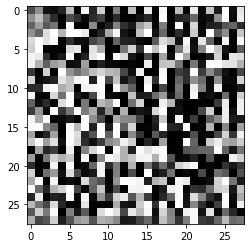

torch.Size([100, 1, 28, 28])


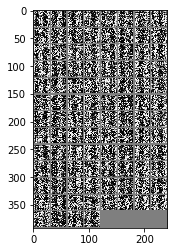

In [10]:
gen = Generator()
disc = Discriminator()

def sample_z(batch_size = 1, N_noise=100):
    if cuda_available:
        return torch.randn(batch_size, N_noise).cuda()
    else:
        return torch.randn(batch_size, N_noise)
# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = gen(z)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = gen(z)
print(img_fake.shape)
imshow_grid(img_fake)

In [0]:
criterion = torch.nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:

        if cuda_available:
            img_batch  = img_batch.cuda()
            label_batch = label_batch.cuda()

        # Learn Discriminator
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(batch_size, -1 , 28, 28))
        p_fake = discriminator(generator(sample_z(batch_size, num_noise)))
        
        ones = torch.ones_like(p_real)
        zeros = torch.zeros_like(p_real)
        if cuda_available:
            ones = ones.cuda()
            zeros = zeros.cuda()

        loss_d = criterion(p_real, ones) + criterion(p_fake, zeros)
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()


        # Learn Generator
        _optimizer_g.zero_grad()
        p_fake = discriminator(generator(sample_z(batch_size, num_noise)))
                
        ones = torch.ones_like(p_fake)
        if cuda_available:
            ones = ones.cuda()

        loss_g = criterion(p_fake, ones)
        loss_g.backward()
   
        # Update parameters
        _optimizer_g.step()
          
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in test_data_loader:
        
        if cuda_available:
            img_batch = img_batch.cuda()
            label_batch = label_batch.cuda()
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(batch_size, -1 , 28, 28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, num_noise)))).item())/10000.
            
            
    return p_real, p_fake

(epoch 10/200) p_real: 0.593736, p_g: 0.400822


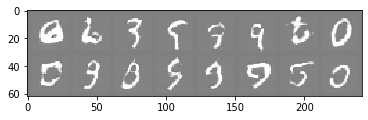

(epoch 20/200) p_real: 0.601093, p_g: 0.070747


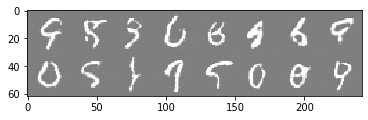

In [0]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            torch.nn.init.xavier_normal_(p)
        else:
            torch.nn.init.uniform_(p, 0.1, 0.2)

init_params(gen)
init_params(disc)


optimizer_g = torch.optim.Adam(gen.parameters(), lr = 0.0002)
optimizer_d = torch.optim.Adam(disc.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):
    run_epoch(gen, disc, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(gen,disc)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    if((epoch+1)% 10 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(gen(sample_z(16)).view(-1, 1, 28, 28))